# Deep Residual Learning for Image Recognition: CIFAR-10 

This notebook provides a PyTorch implementation of *Deep Residual Learning for Image Recogniton* by Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Han Sun which achived state of the art in 2015 by winning the ILSVRC and COCO challenges.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

from resnet import ResNet
from data_loader import get_data_loaders, plot_images
from utils import calculate_normalisation_params
from train import train


import warnings
warnings.filterwarnings('ignore')

In [3]:
# GLOBALS
# -----------------------

data_dir = 'data/cifar10'
batch_size = 128


## Data augmentation: Training set

Files already downloaded and verified
Files already downloaded and verified


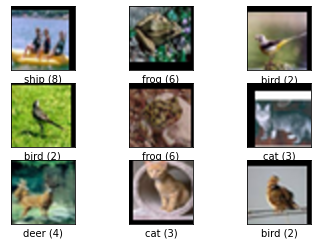

torch.Size([128, 3, 32, 32])


In [4]:
# VISUALISE
# -----------------------

# Load data without normalisations

train_transform = transforms.Compose([
    # 4 pixels are padded on each side, 
    transforms.Pad(4),
    # a 32×32 crop is randomly sampled from the 
    # padded image or its horizontal flip.
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(32),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    # For testing, we only evaluate the single 
    # view of the original 32×32 image.
    transforms.ToTensor()
])

train_loader, test_loader = get_data_loaders(data_dir,
                                             batch_size,
                                             train_transform,
                                             test_transform,
                                             shuffle=True,
                                             num_workers=4,
                                             pin_memory=True)


# Training images
data_iter = iter(train_loader)
images, labels = data_iter.next()
X = images.numpy().transpose([0, 2, 3, 1])
plot_images(X, labels)
print(images.shape)

The training set consists of 50,000 32x32 pixel images. These are padded with 4 pixels on each side, before a crop is randomly sampled from the padded image or its horziontal flip. 

The authors cite C.-Y. Lee, S. Xie, P. Gallagher, Z. Zhang, and Z. Tu. Deeply-supervised nets. arXiv:1409.5185, 2014. This paper suggests that 'corner cropping' should be used which could be interpretted one of two ways:

1. There are five possible crops for each image, centre and then four further crops with the crop placed tightly in each corner. This equates to `torchvision.transforms.FiveCrop()` in PyTorch.
2. The crop position is randomly selected from any possible position within the bounds of the padded image. Equivalent to `torchvision.transforms.RandomCrop()` in PyTorch.

The intended implementation seem ambiguous to me, so I implemented the latter here largely for simplicity.

## Data augmentation: Test set

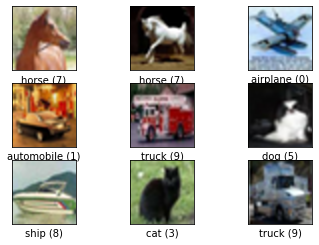

torch.Size([128, 3, 32, 32])


In [5]:
# Test images
data_iter = iter(test_loader)
images, labels = data_iter.next()
X = images.numpy().transpose([0, 2, 3, 1])
plot_images(X, labels)
print(images.shape)

There are 10,000 images in the test set. These are not transformed.

## Calculate normalisation parameters

The authors don't explicitly state if the images are normalised prior to training, however the paper referenced on preprocessing (C.-Y. Lee, S. Xie, P. Gallagher, Z. Zhang, and Z. Tu. Deeply-supervised nets. arXiv:1409.5185, 2014) notes that normalisation is used. 

I was unsure if the mean and standard deviation of the dataset should be calculated before or after augmentation for this purpose. It is also unclear if these calcualations should be done across the training and test set combined, or only the training set.

Her I've used the pre-transform training and test set combined.

In [6]:
# NORMALIZATION
# -----------------------
# Calculate the mean and standard deviation of each channel
# for all observations in training and test datasets. The
# results can then be used for normalisation

# Load data without transforms

train_transform = transforms.Compose([
    # 4 pixels are padded on each side, 
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    # For testing, we only evaluate the single 
    # view of the original 32×32 image.
    transforms.ToTensor()
])

train_loader, test_loader = get_data_loaders(data_dir,
                                             batch_size,
                                             train_transform,
                                             test_transform,
                                             shuffle=True,
                                             num_workers=4,
                                             pin_memory=True)


# Takes a while to run so I've hardcoded results below

means, stds = calculate_normalisation_params(train_loader, test_loader)
print(f'means: {means}')
print(f'stds: {stds}')

Files already downloaded and verified
Files already downloaded and verified
means: [0.49186879012009377, 0.49187015500295705, 0.4918496258567187]
stds: [0.24697121702735994, 0.24696631031035093, 0.24697719258990417]


## Preprocessing

Here we finalise data augmentation and normalisation parameters ahead of training.

In [7]:
# SET FINAL TRANSFORMS WITH NORMALISATION

# [x] simple data augmentation in [24]
# [x] 4 pixels are padded on each side, 
# [x] and a 32×32 crop is randomly sampled from the padded image or its horizontal flip.
# [x] For testing, we only evaluate the single view of the original 32×32 image.


# Normalisation parameters fo CIFAR10
means = [0.4918687901200927, 0.49185976472299225, 0.4918583862227116]
stds  = [0.24697121702736, 0.24696766978537033, 0.2469719877121087]

normalize = transforms.Normalize(
    mean=means,
    std=stds,
)

train_transform = transforms.Compose([
    # 4 pixels are padded on each side, 
    transforms.Pad(4),
    # a 32×32 crop is randomly sampled from the 
    # padded image or its horizontal flip.
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(32),
    transforms.ToTensor(),
    normalize
])

test_transform = transforms.Compose([
    # For testing, we only evaluate the single 
    # view of the original 32×32 image.
    transforms.ToTensor(),
    normalize
])

Notes:

- Note: downsampling with stride 2 results in uneven convolution, e.g. W_out is 16.5. Why didn't the authors use Maxpooling, would have been neater.

## Training

The authors report their results in term of training iterations. I've assumed an iteration here means a forwards and backwards pass of a batch of 128 observations through the entire network.

It seems more convenient to work in epochs in PyTorch, so here I calculate the integer number of iterations per epoch for later conversions. The results is 391 iterations per epoch. An epoch is a forwards and backwards pass for all observations in the training set.

In [8]:
# How many iterations in an epoch?

iterations = 0
for i, data in enumerate(train_loader, 0):
    iterations +=1
print(iterations)

391


### Hyperparameters

Set the hyperparameters as described by the authors, with iterations converted to epochs where appropriate.

In [9]:
# TRAINING PARAMETERS
# -------------------------

# Authors cite 64k iterations
# 64000/391 = 164
epochs = 164

# OPTIMISER PARAMETERS
lr = 0.1 # authors cite 0.1
momentum = 0.9
weight_decay = 0.0001 

# LEARNING RATE ADJUSTMENT
# Reduce learning rate at iterations 
# 32k and 48k. Convert to epochs:
# e.g. iterations / (n_observations/batch_size) 
# 32000/391 = 82
# 48000/391 = 123
milestones = [82, 123]
# Divide learning rate by 10 at each milestone
gamma = 0.1

In [11]:
from mono_depth import MonoDepth

train_loader, test_loader = get_data_loaders(data_dir,
                                            batch_size,
                                            train_transform,
                                            test_transform,
                                            shuffle=True,
                                            num_workers=4,
                                            pin_memory=True)

model = MonoDepth()
criterion = torch.nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
results_file ='results/MonoDepth80.csv'
model_file = 'pretrained/MonoDepth80.pt'
train(model, epochs, train_loader, test_loader, criterion, 
          optimizer, results_file, scheduler=scheduler, MODEL_PATH=model_file)

Files already downloaded and verified
Files already downloaded and verified
cuda:0
Epoch 	Batch 	NLLLoss_Train
1 	50 	2.273
1 	100 	2.181
1 	150 	2.120
1 	200 	2.075
1 	250 	2.051
1 	300 	2.056
1 	350 	2.024
train_err: 0.74278 test_err: 0.7483
2 	50 	2.023
2 	100 	1.999
2 	150 	1.976
2 	200 	1.987
2 	250 	1.973
2 	300 	1.956
2 	350 	1.948
train_err: 0.71918 test_err: 0.7208
3 	50 	1.925
3 	100 	1.921
3 	150 	1.921
3 	200 	1.894
3 	250 	1.904
3 	300 	1.905
3 	350 	1.887
train_err: 0.7064 test_err: 0.7202
4 	50 	1.890
4 	100 	1.887
4 	150 	1.868
4 	200 	1.870
4 	250 	1.858
4 	300 	1.854
4 	350 	1.875
train_err: 0.6904 test_err: 0.6866
5 	50 	1.875
5 	100 	1.852
5 	150 	1.837
5 	200 	1.861
5 	250 	1.849
5 	300 	1.846
5 	350 	1.844
train_err: 0.68978 test_err: 0.7043
6 	50 	1.849
6 	100 	1.842
6 	150 	1.842
6 	200 	1.825
6 	250 	1.835
6 	300 	1.839
6 	350 	1.823
train_err: 0.6761 test_err: 0.6849
7 	50 	1.829
7 	100 	1.826
7 	150 	1.836
7 	200 	1.833
7 	250 	1.822
7 	300 	1.807
7 	350 	1.8

59 	200 	1.605
59 	250 	1.605
59 	300 	1.616
59 	350 	1.615
train_err: 0.57072 test_err: 0.6167
60 	50 	1.616
60 	100 	1.620
60 	150 	1.601
60 	200 	1.625
60 	250 	1.591
60 	300 	1.609
60 	350 	1.610
train_err: 0.58302 test_err: 0.6071
61 	50 	1.603
61 	100 	1.600
61 	150 	1.598
61 	200 	1.622
61 	250 	1.600
61 	300 	1.607
61 	350 	1.604
train_err: 0.5809 test_err: 0.605
62 	50 	1.598
62 	100 	1.611
62 	150 	1.577
62 	200 	1.598
62 	250 	1.612
62 	300 	1.611
62 	350 	1.597
train_err: 0.57352 test_err: 0.611
63 	50 	1.600
63 	100 	1.596
63 	150 	1.615
63 	200 	1.616
63 	250 	1.588
63 	300 	1.605
63 	350 	1.604
train_err: 0.56746 test_err: 0.5871
64 	50 	1.617
64 	100 	1.595
64 	150 	1.618
64 	200 	1.601
64 	250 	1.622
64 	300 	1.592
64 	350 	1.608
train_err: 0.56482 test_err: 0.5889
65 	50 	1.601
65 	100 	1.606
65 	150 	1.584
65 	200 	1.606
65 	250 	1.629
65 	300 	1.583
65 	350 	1.607
train_err: 0.57974 test_err: 0.6084
66 	50 	1.618
66 	100 	1.599
66 	150 	1.588
66 	200 	1.601
66 	250 

117 	100 	1.548
117 	150 	1.530
117 	200 	1.531
117 	250 	1.548
117 	300 	1.524
117 	350 	1.548
train_err: 0.53882 test_err: 0.571
118 	50 	1.529
118 	100 	1.532
118 	150 	1.531
118 	200 	1.532
118 	250 	1.558
118 	300 	1.548
118 	350 	1.533
train_err: 0.53588 test_err: 0.5682
119 	50 	1.550
119 	100 	1.542
119 	150 	1.533
119 	200 	1.540
119 	250 	1.519
119 	300 	1.548
119 	350 	1.537
train_err: 0.53618 test_err: 0.568
120 	50 	1.537
120 	100 	1.543
120 	150 	1.539
120 	200 	1.552
120 	250 	1.530
120 	300 	1.555
120 	350 	1.542
train_err: 0.5346 test_err: 0.5725
121 	50 	1.541
121 	100 	1.532
121 	150 	1.535
121 	200 	1.540
121 	250 	1.538
121 	300 	1.540
121 	350 	1.554
train_err: 0.53482 test_err: 0.5705
122 	50 	1.547
122 	100 	1.529
122 	150 	1.533
122 	200 	1.545
122 	250 	1.544
122 	300 	1.516
122 	350 	1.542
train_err: 0.53896 test_err: 0.5739
123 	50 	1.531
123 	100 	1.539
123 	150 	1.542
123 	200 	1.551
123 	250 	1.533
123 	300 	1.525
123 	350 	1.546
train_err: 0.542 test_err

MonoDepth(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (relu1): ReLU()
  (block1_up): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (7): ReLU()
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (9): ReLU()
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (11): ReLU()
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (13): ReLU()
    (14): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (15): ReLU()
    (16): Conv2d(64, 64, k

### Plain nets

Run training loop for **'plain' convolutional networks** without shortcuts. Here we run for n={3, 5, 7,9} corresponding to networks of depth 20, 32, 44 and 64 layers. 

In [ ]:
# TRAIN PLAIN NETs

# n determines network size as described in paper
# where total number of layers is (6*n)+2
ns = [3, 5, 7, 9]

# Train plainnets
for n in ns:
    print(f'MODEL SIZE: n={n}')
    # Reload data
    train_loader, test_loader = get_data_loaders(data_dir,
                                                 batch_size,
                                                 train_transform,
                                                 test_transform,
                                                 shuffle=True,
                                                 num_workers=4,
                                                 pin_memory=True)
    
    model = ResNet(n, shortcuts=False)
    criterion = torch.nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
    results_file = f'results/plainnet{6*n+2}.csv'
    model_file = f'pretrained/plainnet{6*n+2}.pt'
    train(model, epochs, train_loader, test_loader, criterion, 
          optimizer, results_file, scheduler=scheduler, MODEL_PATH=model_file)

### Residual nets

Run training loop for residual networks with shortcuts. Here we run for n={3, 5, 7,9} corresponding to networks of depth 20, 32, 44 and 64 layers.


In [ ]:
# TRAIN RESNETs

# n determines network size as described in paper
ns = [3, 5, 7, 9]

# Train resnets
for n in ns:
    print(f'MODEL SIZE: n={n}')
    # Reload data
    train_loader, test_loader = get_data_loaders(data_dir,
                                                 batch_size,
                                                 train_transform,
                                                 test_transform,
                                                 shuffle=True,
                                                 num_workers=4,
                                                 pin_memory=True)
    
    model = ResNet(n, shortcuts=True)
    criterion = torch.nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
    results_file = f'results/resnet{6*n+2}.csv'
    model_file = f'pretrained/resnet{6*n+2}.pt'
    train(model, epochs, train_loader, test_loader, criterion, 
          optimizer, results_file, scheduler=scheduler, MODEL_PATH=model_file)

### Check model

Table 6. in the paper reports that the ResNet model with 20 layers should have 0.27 million trainable parameters. We reproduce that here.

It is noted elsewhere that the plain net should have the same number of parameters for the CIFAR10 experiment. This is because an identity mapping is used for the residual shortcuts, as opposed to a convolutional layer, an so there are no additional trainable parameters.

In [ ]:
print(f'Parameter count: {sum([p.numel() for p in model.parameters()])}')

The PyTorch model architecture for a 20 layer model.

In [ ]:
print(model)

## Analysis

### Plain net

First we compare the performance of 'plain' convolutional networks of various depths. This corresponds to the left-hand axis of Figure. 6 in the paper. 

In [ ]:
ns  = [3, 5, 7, 9]
clr = ['y', 'c', 'g', 'r']


plainnet_dfs = [pd.read_csv(f'results/plainnet{6*n+2}.csv') for n in ns]
fig = plt.figure(figsize=(20, 10))
plt.axis([0, 164, 0, 20])


for i in range(len(ns)):
    plt.plot(plainnet_dfs[i]['epoch'], plainnet_dfs[i]['train_err']*100, f'{clr[i]}--',
             label=f'plain-{6*ns[i]+2} train')
    plt.plot(plainnet_dfs[i]['epoch'], plainnet_dfs[i]['test_err']*100, f'{clr[i]}',
             label=f'plain-{6*ns[i]+2} test')

plt.title('Comparison of four plain convolutional networks with 20, 32, 44 and 56 layers.')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('error (%)')
plt.axhline(10, color='black', alpha=0.5, dashes=(10., 10.))
plt.axhline(5, color='black', alpha=0.5, dashes=(10., 10.));

In [ ]:
bests = [df[df['test_err'] == df['test_err'].min()].iloc[0] for df in plainnet_dfs]
bests_df= pd.concat(bests, axis=1).T
bests_df['model'] = ['PlainNet20', 'PlainNet32', 'PlainNet44', 'PlainNet56']
display(bests_df[['model', 'test_err']])

### Resnet

In [ ]:
ns  = [3, 5, 7, 9]
clr = ['y', 'c', 'g', 'r']

resnet_dfs = [pd.read_csv(f'results/resnet{6*n+2}.csv') for n in ns]
fig = plt.figure(figsize=(20, 10))
plt.axis([0, 164, 0, 20])


for i in range(len(ns)):
    plt.plot(resnet_dfs[i]['epoch'], resnet_dfs[i]['train_err']*100, f'{clr[i]}--',
             label=f'ResNet-{6*ns[i]+2} train')
    plt.plot(resnet_dfs[i]['epoch'], resnet_dfs[i]['test_err']*100, f'{clr[i]}',
             label=f'ResNet-{6*ns[i]+2} test')

plt.title('Comparison of four residual networks with 20, 32, 44 and 56 layers.')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('error (%)')
plt.axhline(10, color='black', alpha=0.5, dashes=(10., 10.))
plt.axhline(5, color='black', alpha=0.5, dashes=(10., 10.));

In [ ]:
bests = [df[df['test_err'] == df['test_err'].min()].iloc[0] for df in resnet_dfs]
bests_df= pd.concat(bests, axis=1).T
bests_df['model'] = ['ResNet20', 'ResNet32', 'ResNet44', 'ResNet56']
display(bests_df[['model', 'test_err']])


## Side-by-side plot

In [ ]:
ns  = [3, 5, 7, 9]
clr = ['y', 'c', 'g', 'r']


f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25, 7))

plainnet_dfs = [pd.read_csv(f'results/plainnet{6*n+2}.csv') for n in ns]
resnet_dfs = [pd.read_csv(f'results/resnet{6*n+2}.csv') for n in ns]

def plot_results(dfs, ax, title):
    ax.axis([0, 164, 0, 20])
    
    for i in range(len(ns)):
        ax.plot(dfs[i]['epoch'], dfs[i]['train_err']*100, f'{clr[i]}--',
                 label=f'plain-{6*ns[i]+2} train')
        ax.plot(dfs[i]['epoch'], dfs[i]['test_err']*100, f'{clr[i]}',
                 label=f'plain-{6*ns[i]+2} test')
    
    ax.set_title(title)
    ax.legend(loc='bottom left')
    ax.set_xlabel('epochs')
    ax.set_ylabel('error (%)')
    ax.axhline(10, color='black', alpha=0.5, dashes=(10., 10.))
    ax.axhline(5, color='black', alpha=0.5, dashes=(10., 10.));
    
plot_results(plainnet_dfs, ax1, 'Plain Networks')
plot_results(resnet_dfs, ax2, 'Residual Networks')